In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Run this code only once to create a directory named 'amazon' where we will save our models and parameters
#as when necessery.

import os
os.mkdir('/content/drive/My Drive/amazon')

# Amazon Fine Food Reviews Analysis using Reccurrent Neural Networks.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

#### Basic information about the downloaded dataset<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.
In this problem we will apply classification techniques called Naive Bayes to get an idea if the data can be seperated based on its polarity, i.e. if the review is positive or negative. By looking at the Score column we can make out that the review is positive or not. But we don't need to implement any ML here. A simple if-else condition will make us do this. So for this problem, we will put our focus on to the Review text. The text is the most important feature here if you may ask. Based on the review text we will build a prediction model and determine if a future review is positive or negative.

#### While pre-processing the original dataset we have taken into consideration the following points.

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 4 or 5.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 1 or 2.
3. We will ignore the reviews for the time being which has a Score rating of 3. Because 3 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset.
5. For this problem we will consider a sample size of 50000 reviews sampled randomly from the original dataset. I have done this because I don't have a huge RAM size (12 GB to be specific). 
6. We will train our final mdel using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
7. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative (Determining the sentiment polarity of the Amazon reviews)

In [0]:
#Importing all the neccessary libraries
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn import datasets, neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
import math
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import os
from datetime import datetime

#### The immediate code block below does the following things :

1. Load the Amazon dataset.
2. Classify the reviews initially based on their score rating and give them a 'Positve' or a 'Negative' tag.
3. Remove duplicate/redundant datas.
4. Get an idea of how much percentage data were actually duplicates.
5. Plot a histogram which will display the distribution of the number of positive and negative reviews after de-duplication.

###### NOTE : If we dont' clean the data and feed them to an ML system, it basically means we are throwing in a lot of garbage data to the ML system. If we give it garbage, it will give us garbage back. So it's utmost important to clean the data before proceeding.

<h3>Loading the Amazon Food reviews dataset.</h3>

In [0]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
if os.path.isfile('/content/drive/My Drive/amazon/database.sqlite'):
    connection_sqlobject = sqlite3.connect('/content/drive/My Drive/amazon/database.sqlite')
    #Filter only positive and negative reviews. Do not consider reviews with score = 3.
    dataframe = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)
    dataframe = dataframe.fillna('')
    connection_sqlobject.close()
else:
    print("Get database.sqlite from drive or run the previous notebook.")
    
dataframe.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


<h3>1. Encode the reviews as positive and negative. <br>
2. Remove the duplicate entries from the dataset. <br>
3. Drop unwanted columns from the dataset. <br>
4. Sort the reviews according to Time, such that the oldest reviews are displayed at the top and the latest reviews are displayed at the bottom.</h3>

In [0]:
#This function will remove the duplicate reviews.
def dedup(dataframe):
    #Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag. Ignore all scores with value 3.
    dataframe['SentimentPolarity'] = dataframe['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
    dataframe['Class_Labels'] = dataframe['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

    #Display information about the dataset before the removal of duplicate data.
    print("The shape of the filtered matrix : {}".format(dataframe.shape))
    print("The median score values : {}".format(dataframe['Score'].mean()))
    print("The number of positive and negative reviews before the removal of duplicate data.")
    print(dataframe["Class_Labels"].value_counts())

    #Removing duplicate entries based on past knowledge.
    filtered_duplicates=dataframe.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

    #Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
    final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

    #Display information about the dataset after the removal of duplicate data.
    print("\nThe shape of the data matrix after deduplication : {}".format(final_data.shape))
    print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
    print("The number of positive and negative reviews after the removal of duplicate data.")
    print(final_data["Class_Labels"].value_counts())

    #Checking to see how much % of data still remains.
    print("\nChecking to see how much percentage of data still remains.")
    retained_per = (final_data['Class_Labels'].size*1.0)/(dataframe['Class_Labels'].size*1.0)*100
    removed_per = 100 - retained_per
    print("Percentage of redundant data removed : {}".format(removed_per))
    print("Percentage of original data retained : {}".format(retained_per))
    
    dataframe = final_data
    
    #Dropping unwanted columns for now.
    dataframe=dataframe.drop(labels=['Id','ProductId', 'UserId', 'Score', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Summary','SentimentPolarity'], axis=1)
    print("The shape of the sampled dataset after dropping unwanted columns : ", dataframe.shape)
    
    #Sorting data according to Time in ascending order => Time Based Splitting Step 1.
    dataframe=dataframe.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
    dataframe = dataframe.reset_index()
    dataframe=dataframe.drop(labels=['index'], axis=1)
    
    return dataframe
    
dataframe=dedup(dataframe)

#Display the first 10 rows of the dataframe (All the reviews are arranged according to time)
print("\nFirst 10 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
dataframe.head(10)

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
1    443777
0     82037
Name: Class_Labels, dtype: int64

The shape of the data matrix after deduplication : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
1    307061
0     57110
Name: Class_Labels, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194
The shape of the sampled dataset after dropping unwanted columns :  (364171, 3)

First 10 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Time,Text,Class_Labels
0,1351209600,I just got this coffee a few days ago. I had c...,0
1,1351209600,Very pleased with the quality of the espresso....,1
2,1351209600,Bought this with my new Oster Belgium waffle m...,1
3,1351209600,We drink a lot of tea... from all over the wor...,0
4,1351209600,I have always bought my pure vanilla extract i...,1
5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",1
6,1351209600,"Best soup mix I've tried. I love making soup, ...",1
7,1351209600,try it & we shared with the familys/all han th...,1
8,1351209600,If you like butter flavor this is the best mic...,1
9,1351209600,I love all sorts of teas. My friends know this...,1


<h3> Displaying information about the number of postive and negative reviews in the sampled dataset, using a Histogram. </h3>

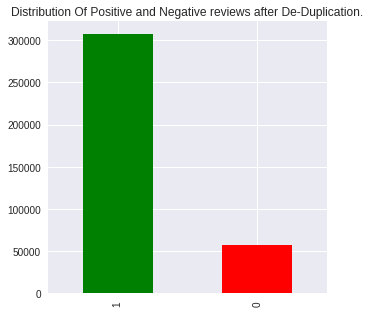

In [0]:
#Display distribution of Postive and Negative reviews in a bar graph
dataframe["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))

#### Data cleaning stage : Clean each review from the Amazon reviews Dataset.

In [0]:
#Function to clean html tags from a review
def removeHtml(review): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',review)
    return cleaned_text

#Function to keep only words containing letters A-Z and a-z and 0-9. This will remove all punctuations, special characters etc.
def removePunctuations(review):
    cleaned_text  = re.sub('[^a-zA-Z0-9]',' ',review)
    return cleaned_text

'''
#Scrapping the data from: https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions to get english contractions and expansions.
import pandas as pd
wiki_dfs = pd.read_html('https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions',header=0)
for dataframe in wiki_dfs:
    print(dataframe)
    
import re
def remove_braces(data): 
    pattern1 = re.compile("[\(\[].*?[\)\]]")
    cleaned_text = re.sub(pattern1,'',data)
    return cleaned_text

def truncate(text):
    string=''
    array = text.split()
    
    if(',' in text):
        string='is'
    else:
        index = array.index('/')    
        for ele in range(0,index):
            word = array[ele]
            string = string + " "+ word
            string=string.strip()
    return string
        
filtered_meaning=[]
for meaning in dataframe['Meaning'].values:
    temp_list = []
    meaning=remove_braces(meaning)
    if(('/' in meaning) or (',' in meaning)):
        meaning=truncate(meaning)
    string = "".join(meaning)
    filtered_meaning.append(string)
    
dataframe['Meaning'] = filtered_meaning'''
    

#Expand the reviews
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's","how has").replace("y'all","you all")\
                           .replace("o'clock","of the clock").replace("ne'er","never").replace("let's","let us")\
                           .replace("finna","fixing to").replace("gonna","going to").replace("gimme","give me").replace("gotta","got to").replace("'d"," would")\
                           .replace("daresn't","dare not").replace("dasn't","dare not").replace("e'er","ever").replace("everyone's","everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [0]:
from datetime import datetime
start = datetime.now()

#Stemming and stopwords removal
import re
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
import nltk
nltk.download('stopwords')
  
default_stopwords = set(stopwords.words('english'))
remove_not = set(['not'])
custom_stopwords = default_stopwords - remove_not

#Building a data corpus by removing all stopwords except 'not'. Because 'not' can be an important estimator to differentiate between positive and negative reviews.    
count=0                   #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
data_corpus=[]
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
stemed_word=''

for review in dataframe['Text'].values:
    filtered_review=[]
    review=removeHtml(review) #Remove HTMl tags
    review = preprocess(review)
    
    for word in review.split():
        for cleaned_words in removePunctuations(word).split():
            if(cleaned_words.isalpha() & (len(cleaned_words)>2)):   #Ignoring words whose length is less than or equal to 2.
                if(cleaned_words.lower() not in custom_stopwords):
                    stemed_word=(sno.stem(cleaned_words.lower()))
                    filtered_review.append(stemed_word)
                    if (dataframe['Class_Labels'].values)[count] == 1: 
                        all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
                    if(dataframe['Class_Labels'].values)[count] == 0:
                        all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
                else:
                    continue
            else:
                continue 
    string = " ".join(filtered_review) #Final string of cleaned words    
    data_corpus.append(string) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
print("\nTime taken to clean all reviews:", datetime.now() - start) 

print("The length of the data corpus is : {}".format(len(data_corpus)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
dataframe['ProcessedText']=data_corpus 

print("Printing the number of positive and negative reviews after data cleaning.")
print(dataframe['Class_Labels'].value_counts())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

Time taken to clean all reviews: 0:08:08.180631
The length of the data corpus is : 364171
Printing the number of positive and negative reviews after data cleaning.
1    307061
0     57110
Name: Class_Labels, dtype: int64


In [0]:
#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('/content/drive/My Drive/amazon/RNN_AmazonReviews.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
dataframe.to_sql('Reviews', connection_sqlobject, if_exists='replace', index=True)
connection_sqlobject.close()

import pickle
with open('/content/drive/My Drive/amazon/data_corpus.pkl', 'wb') as f:
    pickle.dump(data_corpus, f)
    
with open('/content/drive/My Drive/amazon/all_positive_words.pkl', 'wb') as f:
    pickle.dump(all_positive_words, f)
    
with open('/content/drive/My Drive/amazon/all_negative_words.pkl', 'wb') as f:
    pickle.dump(all_negative_words, f)

In [0]:
#Creating the connection with database file.
if os.path.isfile('/content/drive/My Drive/amazon/RNN_AmazonReviews.sqlite'):
    connection = sqlite3.connect('/content/drive/My Drive/amazon/RNN_AmazonReviews.sqlite')
    dataframe = pd.read_sql_query("""SELECT * from Reviews""", connection)
    connection.close() #Always remember to close the database
else:
    print("File not present!")

In [0]:
#Check if there are any null rows.
nan_rows = dataframe[dataframe.isnull().any(1)]
print(nan_rows)

#Display the table after cleaning the texts.
dataframe.head(10)

Empty DataFrame
Columns: [index, Time, Text, Class_Labels, ProcessedText]
Index: []


,index,Time,Text,Class_Labels,ProcessedText
0,0,1351209600,I just got this coffee a few days ago. I had c...,0,got coffe day ago coffe bean yesterday today m...
1,1,1351209600,Very pleased with the quality of the espresso....,1,pleas qualiti espresso pod sturdi enough withs...
2,2,1351209600,Bought this with my new Oster Belgium waffle m...,1,bought new oster belgium waffl maker best waff...
3,3,1351209600,We drink a lot of tea... from all over the wor...,0,drink lot tea world far worst tast tea purchas...
4,4,1351209600,I have always bought my pure vanilla extract i...,1,alway bought pure vanilla extract mexico got t...
5,5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",1,label cadburi screme egg allergi inform manufa...
6,6,1351209600,"Best soup mix I've tried. I love making soup, ...",1,best soup mix tri love make soup best tast eas...
7,7,1351209600,try it & we shared with the familys/all han th...,1,tri share famili han thumb cut good lite oliv ...
8,8,1351209600,If you like butter flavor this is the best mic...,1,like butter flavor best microwav popcorn avail...
9,9,1351209600,I love all sorts of teas. My friends know this...,1,love sort tea friend know travel often bring t...


<h3>Display top 50 most frequently occuring Positive and Negative words.</h3>

In [0]:
import pickle
with open('/content/drive/My Drive/amazon/all_positive_words.pkl', 'rb') as f:
    all_positive_words=pickle.load(f)
with open('/content/drive/My Drive/amazon/all_negative_words.pkl', 'rb') as f:
    all_negative_words=pickle.load(f)


freq_positive=nltk.FreqDist(all_positive_words)
freq_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_positive.most_common(50))
print("\nMost Common Negative Words : ",freq_negative.most_common(50))

Most Common Positive Words :  [('not', 293997), ('like', 141050), ('tast', 131306), ('good', 113837), ('flavor', 111644), ('love', 107727), ('great', 104581), ('use', 104342), ('one', 97737), ('product', 92279), ('tri', 87158), ('tea', 84869), ('coffe', 79785), ('make', 75417), ('would', 72872), ('get', 72271), ('food', 65611), ('time', 56216), ('buy', 54320), ('realli', 52810), ('eat', 52304), ('amazon', 50035), ('price', 49480), ('also', 48134), ('find', 48133), ('much', 47924), ('best', 47840), ('order', 47247), ('littl', 46172), ('well', 43650), ('drink', 42909), ('store', 42462), ('dog', 41522), ('bag', 41218), ('even', 38903), ('cup', 38864), ('mix', 37326), ('day', 36620), ('chocol', 36588), ('better', 36588), ('year', 35273), ('sugar', 34575), ('recommend', 34443), ('sweet', 34371), ('water', 33191), ('box', 32314), ('high', 31360), ('found', 31153), ('first', 30493), ('brand', 30023)]

Most Common Negative Words :  [('not', 95671), ('tast', 35197), ('like', 32793), ('product',

<h3>Analysis of Words : Total number of unique words.</h3>

In [0]:
start = datetime.now()

# Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool.
cv_object = CountVectorizer(tokenizer = lambda x: x.split()) #By default 'split()' will tokenize each tag using space.

# fit_transform() does two functions: First, it fits the model and learns the vocabulary; second, it transforms our training data into feature vectors. The input to fit_transform should be a list of strings.
words_vectorized = cv_object.fit_transform(dataframe['ProcessedText'])
print("\nTime taken to vectorize the words into BOW representation:", datetime.now() - start)

print("Number of unique words in our vocalbulary:", words_vectorized.shape[1])

#'get_feature_name()' gives us the vocabulary.
words = cv_object.get_feature_names()

#Lets look at the words we have.
print("\nSome of the random words we have :\n", words[200:400])


Time taken to vectorize the words into BOW representation: 0:00:10.432750
Number of unique words in our vocalbulary: 71995

Some of the random words we have :
 ['abras', 'abreast', 'abreva', 'abrevi', 'abridg', 'abrir', 'abroa', 'abroad', 'abrook', 'abrotanum', 'abrubt', 'abrupt', 'abruzzi', 'abruzzo', 'absalut', 'abscess', 'abscond', 'absenc', 'absens', 'absensc', 'absent', 'absentmind', 'absinth', 'absinthett', 'absinthium', 'abslut', 'abso', 'absofrigginlut', 'absolet', 'absolout', 'absolt', 'absolu', 'absoluet', 'absoluey', 'absoluit', 'absoluley', 'absolultey', 'absolulti', 'absolulut', 'absolust', 'absolut', 'absolutali', 'absolutament', 'absoluteki', 'absolutel', 'absoluteley', 'absolutelli', 'absolutelt', 'absolutelti', 'absoluteti', 'absolutey', 'absolutl', 'absolutley', 'absolutt', 'absolutuley', 'absolv', 'absoprt', 'absorb', 'absorbt', 'absorpt', 'absort', 'absoslut', 'absoulout', 'absoult', 'absoultey', 'absoulut', 'absouluti', 'absout', 'abstain', 'abstemi', 'abstin', 'a

<h3>Analysis of Words : Number of times a word appeared. </h3>

In [0]:
#Lets now store the document term matrix in a dictionary.
frequencies = words_vectorized.sum(axis=0).A1 #axis=0 for columns. Column contain the number of times the words have occured
word_frequency = dict(zip(words, frequencies))

#Saving this dictionary to csv files.
import csv
with open('/content/drive/My Drive/amazon/word_frequency.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in word_frequency.items():
        writer.writerow([key, value])

#Load the word_count_df
words_count_df = pd.read_csv("/content/drive/My Drive/amazon/word_frequency.csv", names=['Word', 'Frequency'])

#Display the number of times each tag appeared.
words_count_df.head(10)

,Word,Frequency
0,a,1
1,aa,1
2,aaa,42
3,aaaa,9
4,aaaaa,10
5,aaaaaa,2
6,aaaaaaaaaaa,1
7,aaaaaaaaaaaa,1
8,aaaaaaaaaaaaa,1
9,aaaaaaaaaaaaaa,1


<h3>Analysis of Words : Sort the words by frequency of their occurences. </h3>

In [0]:
words_count_df = pd.read_csv('/content/drive/My Drive/amazon/word_frequency.csv', names=['Word','Frequency'])

#Sort the words according to their number of occurences.
words_count_df_sorted = words_count_df.sort_values(['Frequency'], ascending=False)
words_count_df_sorted.reset_index(drop=False)
words_count_df_sorted['Rank'] = [i for i in range(1,len(words_count_df['Word'])+1)]

words_count_df_sorted=words_count_df_sorted.set_index('Rank')

#Save this dataframe
connection_sqlobject = sqlite3.connect('/content/drive/My Drive/amazon/RNN_Words_Freq_Rank.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
words_count_df_sorted.to_sql('Rank', connection_sqlobject, if_exists='replace', index=True)
connection_sqlobject.close()

words_count_df_sorted

,Word,Frequency
Rank,,
1,not,389668
2,like,173843
3,tast,166503
4,flavor,131665
5,good,129025
6,product,120976
7,use,119711
8,one,118531
9,love,116279


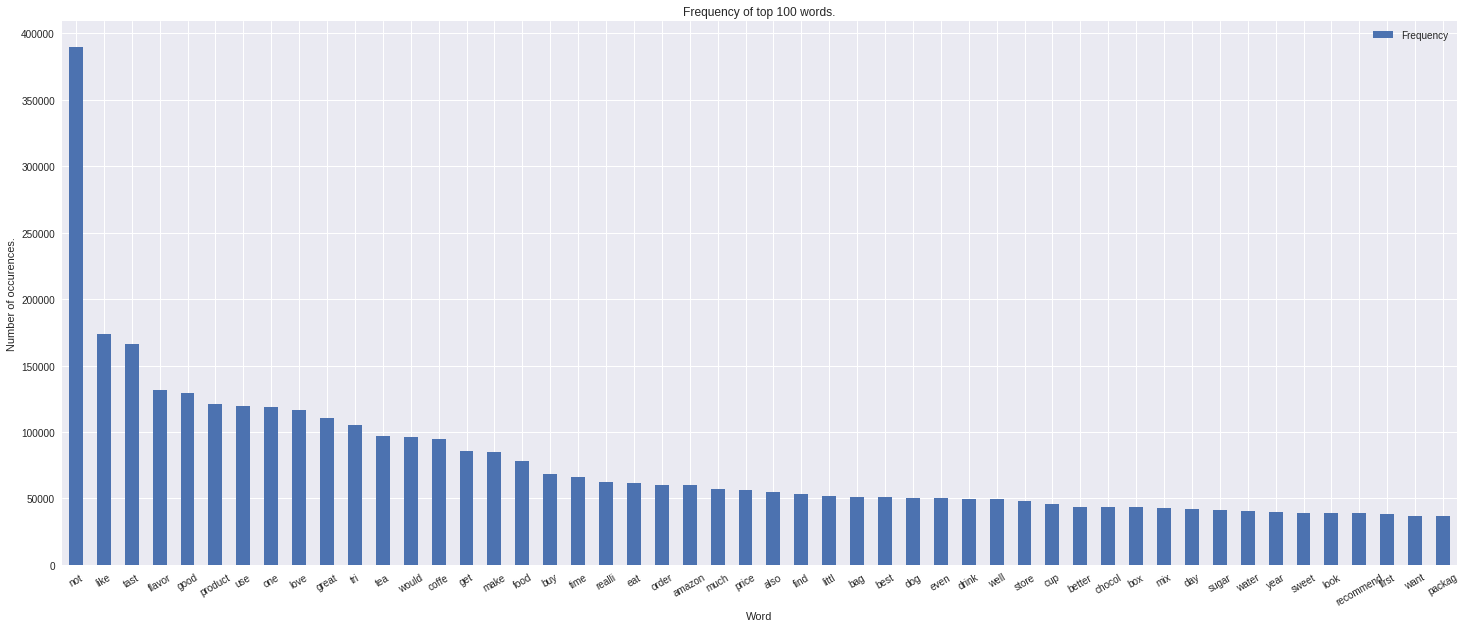

In [0]:
i=np.arange(50)
words_count_df_sorted.head(50).plot.bar(figsize=(25,10))
plt.title('Frequency of top 100 words.')
plt.xticks(i, words_count_df_sorted['Word'],rotation=30)
plt.xlabel('Word')
plt.ylabel('Number of occurences.')
plt.show()

<h3>Encoding each review based on the Ranks of words present in each of them. </h3>

In [0]:
keys = list(words_count_df_sorted['Word'])
values = list(words_count_df_sorted['Frequency'])
dictionary = dict(zip(keys, values))

start = datetime.now()
encoded_reviews = []
omit=['nan','null'] #Few words were contaning null and nan
for review in dataframe['ProcessedText'].values:
    review_encode=[]
    for word in review.split():
        if(word not in omit):
            rank=dictionary[str(word)] #Get rank of the word
            review_encode.append(rank) #Encoded values for one single review
    encoded_reviews.append(np.array(review_encode)) #Encoded values for all reviews
    
print("Time taken to encode all the reviews: ", datetime.now()-start)

Time taken to encode all the reviews:  0:00:10.856004


In [0]:
#Display the dataframe after encoding and removing unneccesry columns.
dataframe['EncodedText'] = encoded_reviews
dataframe=dataframe.drop(labels=['index','Time', 'Text'], axis=1)
dataframe = dataframe[['ProcessedText', 'EncodedText','Class_Labels']]
dataframe.head(10)

,ProcessedText,EncodedText,Class_Labels
0,got coffe day ago coffe bean yesterday today m...,"[26266, 94684, 41730, 9618, 94684, 17211, 1072...",0
1,pleas qualiti espresso pod sturdi enough withs...,"[12327, 22717, 5757, 6402, 838, 20762, 97, 125...",1
2,bought new oster belgium waffl maker best waff...,"[32557, 16446, 28, 196, 2846, 4744, 50820, 284...",1
3,drink lot tea world far worst tast tea purchas...,"[49734, 27662, 96658, 4843, 17747, 2521, 16650...",0
4,alway bought pure vanilla extract mexico got t...,"[23437, 32557, 5720, 12867, 3707, 581, 26266, ...",1
5,label cadburi screme egg allergi inform manufa...,"[7124, 279, 2, 6222, 4738, 2848, 3686, 357, 60...",1
6,best soup mix tri love make soup best tast eas...,"[50820, 13297, 42652, 104956, 116279, 85287, 1...",1
7,tri share famili han thumb cut good lite oliv ...,"[104956, 4550, 14741, 49, 1008, 7877, 129025, ...",1
8,like butter flavor best microwav popcorn avail...,"[173843, 17576, 131665, 50820, 5133, 8938, 125...",1
9,love sort tea friend know travel often bring t...,"[116279, 3749, 96658, 14888, 30042, 3245, 6922...",1


In [0]:
#Saving the dataframe to csv files.
import csv
dataframe.to_csv('/content/drive/My Drive/amazon/Encoded_Reviews_DB.csv')

In [0]:
#Optimize this code later. For the time being use keras to pad zeroes.
'''#Determine the maximum length of a review 
max_review_len=0
for i in range(0,dataframe.shape[0]):
    max_review_len=max(max_review_len,len(dataframe['EncodedText'][i]))
    
#Add zeroes to the reviews
def add_zero(lst):
    nb_zeroes=max_review_len-len(lst)
    zero_vals=np.array([0]*nb_zeroes)
    padded_array = np.hstack((zero_vals,lst))
    return padded_array

#Add zeroes to the reviews
start = datetime.now()
padded_matrix=add_zero(dataframe['EncodedText'][0])
for i in range(1,dataframe.shape[0]):
    np_row=add_zero(dataframe['EncodedText'][i])
    padded_matrix=np.vstack((padded_matrix,np_row))
    
    temp=dataframe.shape[0]//10
    if(i%temp==0):
        print((i/temp)*10,"% completed...")
    elif(i==dataframe.shape[0]-1):
        print("100.0 % completed..")
        
print("Time taken to pad all the reviews: ", datetime.now()-start)

#Convert to numpy matrix and concatenate both of them
X=pd.DataFrame(padded_matrix,columns=[i for i in range(0,padded_matrix.shape[1])])
y=pd.DataFrame(y,columns=['Class_Label'])
encoded_df = pd.concat([X,y],axis=1)'''

In [0]:
#Save all the reviews in encoded format.

with open('/content/drive/My Drive/amazon/encoded_reviews.pkl', 'wb') as f:
    pickle.dump(encoded_reviews, f)
    
y = list(dataframe['Class_Labels'])
with open('/content/drive/My Drive/amazon/class_labels.pkl', 'wb') as f:
    pickle.dump(y, f)

In [0]:
#Load the encoded reviews and class labels from files.
with open('/content/drive/My Drive/amazon/encoded_reviews.pkl', 'rb') as f:
    encoded_reviews = pickle.load(f)
    
with open('/content/drive/My Drive/amazon/class_labels.pkl', 'rb') as f:
     y=pickle.load(f)
    
dataframe=pd.read_csv('/content/drive/My Drive/amazon/Encoded_Reviews_DB.csv')

<h3>#LSTM for sequence classification in the Amazon Reviews dataset</h3>

The average length of reviews:  39.49883983073886
The maximum length of reviews:  1545
The minimum length of reviews:  0


Text(0.5, 0, 'Length of reviews')

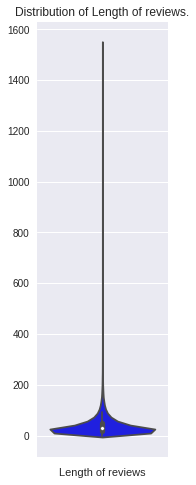

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

max_review_len=0
avg=[]
for i in range(0,len(encoded_reviews)):
    max_review_len=max(max_review_len,len(encoded_reviews[i]))
    avg.append(len(encoded_reviews[i]))

avg=np.array(avg)
print("The average length of reviews: ",avg.mean())
print("The maximum length of reviews: ",avg.max())
print("The minimum length of reviews: ",avg.min())



# plot (normalized) histogram of the data
avg_lens = avg.flatten().reshape(-1,1)

fig = plt.figure(figsize=(8,8))
plt.subplot(1, 3, 1)
plt.title("Distribution of Length of reviews.")
ax = sns.violinplot(y=avg,color='b')
plt.xlabel('Length of reviews')

In [0]:
#Pad the reviews with zeroes at the start. This is done to make all the dimensions equal so that we can send the data points in batches.
#As we can see from the above violin plot, the average length of reviews is 39. Most of the reviews are less than 200 in length, with just a handful of number of reviews having length
#greater than 200. So we will pad all the reviews taking the max length to be 200.

max_review_len=200
   
split = math.floor(0.7*len(encoded_reviews))

from keras.preprocessing import sequence
X_train = sequence.pad_sequences(encoded_reviews[0:split], maxlen=max_review_len)
X_test = sequence.pad_sequences(encoded_reviews[split:], maxlen=max_review_len)

y = dataframe['Class_Labels']

y_train=y[0:split]
y_test=y[split:]

del(encoded_reviews)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Using TensorFlow backend.


(254919, 200)
(254919,)
(109252, 200)
(109252,)


In [0]:
train_df = pd.DataFrame(X_train)
train_df['Class_Labels'] = y_train

test_df = pd.DataFrame(X_test)
test_df['Class_Labels'] = y_test

padded_df=pd.concat([train_df,test_df])

#Save the padded db into google drive
padded_df.to_csv('/content/drive/My Drive/amazon/PaddedReviews_DB.csv')

In [0]:
del(dataframe, all_positive_words, all_negative_words, data_corpus, word_frequency, words_count_df, words_count_df_sorted, train_df, test_df, padded_df)

In [0]:
#This function is used to plot/update the train and test loss after each epoch.
#Reference: https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
#Reference: https://stackoverflow.com/a/14434334

import matplotlib.pyplot as plt
import numpy as np
import time
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
X_train[1]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [0]:
import numpy as np
import math
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

#Create the LSTM model 1.
embedding_vector_length = 128
model = Sequential()
model.add(Embedding(words_vectorized.shape[1], embedding_vector_length, input_length=max_review_len)) #words_vectorized.shape[1]=71995 : Number of unique words we have in our vocabulary.
                                                                                                      #input: words_vectorized.shape[1], output: embedding_vector_length
model.add(LSTM(200))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          9215360   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 9,478,761
Trainable params: 9,478,761
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
#Train the model
history=model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Train on 254919 samples, validate on 109252 samples
Epoch 1/10
254919/254919 [==============================] - 1027s 4ms/step - loss: 0.2482 - acc: 0.9005 - val_loss: 0.2000 - val_acc: 0.9232
Epoch 2/10
254919/254919 [==============================] - 987s 4ms/step - loss: 0.2137 - acc: 0.9139 - val_loss: 0.1939 - val_acc: 0.9242
Epoch 3/10
254919/254919 [==============================] - 981s 4ms/step - loss: 0.1980 - acc: 0.9207 - val_loss: 0.1936 - val_acc: 0.9232
Epoch 4/10
254919/254919 [==============================] - 982s 4ms/step - loss: 0.1847 - acc: 0.9260 - val_loss: 0.1888 - val_acc: 0.9264
Epoch 5/10
254919/254919 [==============================] - 981s 4ms/step - loss: 0.1724 - acc: 0.9311 - val_loss: 0.1903 - val_acc: 0.9265
Epoch 6/10
254919/254919 [==============================] - 970s 4ms/step - loss: 0.1600 - acc: 0.9358 - val_loss: 0.1922 - val_acc: 0.9269
Epoch 7/10
254919/254919 [==============================] - 971s 4ms/step - loss: 0.1459 - acc: 0.9427 - va

Test score (Validation Loss): 0.24480932824215157
Test accuracy (Accuracy on Unseen Data): 92.18137883059349


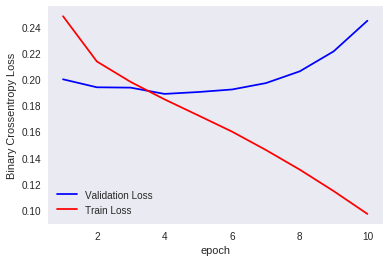

In [0]:
#Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score (Validation Loss):', score[0]) 
print('Test accuracy (Accuracy on Unseen Data):', score[1]*100)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

#List of epoch numbers
x = list(range(1,11))

#print(history.history.keys())
#dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
#history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

#We will get val_loss and val_acc only when we pass the paramter validation_data, val_loss : validation loss, val_acc : validation accuracy

#loss : training loss
#acc : train accuracy
#for each key in histrory.histrory we will have a list of length equal to number of epochs

val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_dynamic(x, val_loss, loss, ax)

#Save the model.
from keras.models import load_model
model.save('/content/drive/My Drive/amazon/LSTM_AmazonReviews.h5') #Load using: model = load_model('LSTM_AmazonReviews.h5')


### Conclusion : 

From the above plot, we can see that the train and test loss are nearly same at the end of 4 epochs.
The train loss and test loss diverge away from each other when we train the model beyond 4 epochs. This means that our model
might be overfitted. We can reduce overfitting by adding dropouts and batch normalization and see if it works.

Accuracy at the end of 10 epochs = 92.18 %

**Adding Dropout to check if it reduces overfitting + RMSProp Optimzer.**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           4607680   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               212000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 4,819,881
Trainable params: 4,819,881
Non-trainable params: 0
_________________________________________________________________
None
Train on 254919 samples, validate on 109252 samples
Epoch 1/10
254919/254919 [==============================] - 1864s 7ms/step 

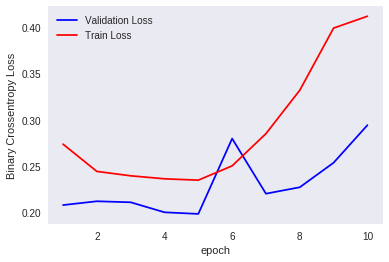

In [0]:
import numpy as np
import math
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)

max_review_len = 200

#Create the LSTM model 2.
embedding_vector_length = 64
model = Sequential()
model.add(Embedding(words_vectorized.shape[1], embedding_vector_length, input_length=max_review_len)) 
                                                                                                      #words_vectorized.shape[1]=71995 : Number of unique words we have in our vocabulary.
                                                                                                      #input: words_vectorized.shape[1], output: embedding_vector_length
model.add(Dropout(0.4))
model.add(LSTM(200))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

#Plot train vs test loss.
#Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score (Validation Loss):', score[0]) 
print('Test accuracy (Accuracy on Unseen Data):', score[1]*100)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

#List of epoch numbers
x = list(range(1,11))

val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_dynamic(x, val_loss, loss, ax)

#Save the model.
from keras.models import load_model
model.save('/content/drive/My Drive/amazon/LSTM_AmazonReviewsDropout.h5') #Load using: model = load_model('LSTM_AmazonReviewsDropout.h5')


**Stacked LSTM + Dropout + RMSPROP Optimzer + Softmax**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          9215360   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 200)          263200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total para

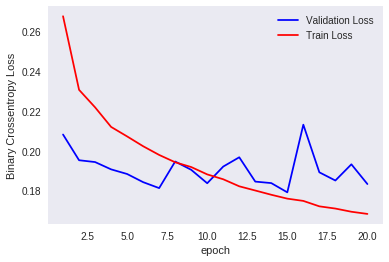

In [0]:
import numpy as np
import math
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)

max_review_len = 200

#Create the LSTM model 2.
embedding_vector_length = 128
model = Sequential()
model.add(Embedding(71995, embedding_vector_length, input_length=max_review_len)) 
                                                                                                      #words_vectorized.shape[1]=71995 : Number of unique words we have in our vocabulary.
                                                                                                      #input: words_vectorized.shape[1], output: embedding_vector_length
model.add(Dropout(0.4))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(200))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())
history=model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test))  #Training this model for 20 epochs. 

#Plot train vs test loss.
#Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score (Validation Loss):', score[0]) 
print('Test accuracy (Accuracy on Unseen Data):', score[1]*100)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

#List of epoch numbers
x = list(range(1,21))

val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_dynamic(x, val_loss, loss, ax)

#Save the model.
from keras.models import load_model
model.save('/content/drive/My Drive/amazon/LSTM_AmazonReviewsDropoutEpoch20.h5') #Load using: model = load_model('LSTM_AmazonReviewsDropoutEpoch20.h5')
